In [4]:
import torch

def LP_IXZ(X, Z, p=2):
    # p can be int, float, inf, -inf, 'fro', 'nuc'
    A_X = torch.sigmoid(X@X.T)
    A_Z = torch.sigmoid(Z@Z.T)

    # return torch.cdist(A_X, A_Z, p)
    return torch.norm(A_X - A_Z, p)

A = torch.rand((25,7))
B = torch.rand((25,9))


# A.shape, A_T.shape, (A@A_T).shape
LP_IXZ(A, B)



tensor(2.1568)

# Visual node emb

Loading cora dataset...


/home/eziao/anaconda3/envs/pyg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eziao/anaconda3/envs/pyg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_23538/200894141.py:40: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.scatterplot(data=df_tsne, palette=sns.color_palette("Set2"), hue='class', x='Dim1', y='Dim2')


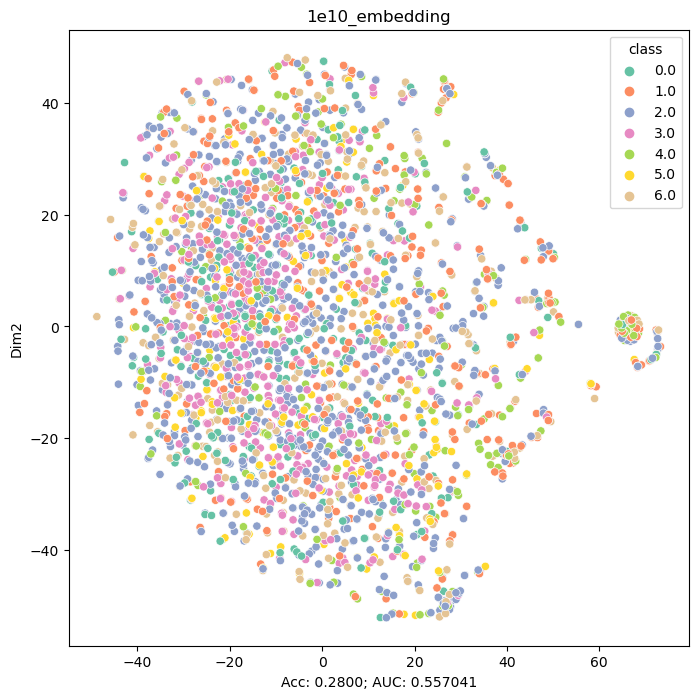

In [4]:
import glob
import os.path as osp
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
import torch

import torch.nn.functional as F




from sklearn.manifold import TSNE 
 
tsne = TSNE(n_components=2) 

from dataset import Dataset
data = Dataset(root='', name='cora', setting='GCN')

adj, features, labels, init_adj = data.adj, data.features, data.labels, data.init_adj

name = '../embedding_1e10.pth'
title = '1e10_embedding'

# data, _, = load_data(dataset_name, 'cpu')
# y = data.y

# node_embedding = torch.load(name).detach().cpu()
node_embedding = torch.load(name).detach().cpu()
node_emb_std = F.normalize(node_embedding, dim=1).numpy()

X_tsne = tsne.fit_transform(node_emb_std) 
X_tsne_data = np.vstack((X_tsne.T, labels)).T 
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2', 'class']) 

df_tsne.head()
plt.figure(figsize=(8, 8)) 
sns.color_palette("hls", 8)
sns.scatterplot(data=df_tsne, palette=sns.color_palette("Set2"), hue='class', x='Dim1', y='Dim2')
plt.title(title) 

plt.xlabel('Acc: 0.2800; AUC: 0.557041')

img_path = title + '.png'
plt.savefig(img_path)
# print(node_embedding.shape)
# visual_embedding(node_embedding, title)
    

In [15]:
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
from torch_geometric.datasets import Planetoid, WebKB, WikipediaNetwork
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.nn.models import GAT, GCN, MLP, GraphSAGE
from tqdm import tqdm, trange


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

CONFIGS = {
    'model': 'GCN',

    'hidden_dim': 32,
    'num_layers': 2,
    'dropout': 0.5,
    'norm': 'None', # 'InstanceNorm', 'DiffGroupNorm', 'MessageNorm', 'BatchNorm', 'MeanSubtractionNorm', 'PairNorm', 'LayerNorm', 'GraphSizeNorm', 'GraphNorm'
    'jk': 'cat', # "last", "cat", "max", "lstm"`

    'dataset_name': 'Cora', # 'wisconsin', 'texas', 'cornell', 'Cora' , 'chameleon', 'squirrel'
    'Epochs': 201,

}

model = eval(CONFIGS['model'])(
        in_channels=500,
        hidden_channels=CONFIGS['hidden_dim'],
        num_layers=CONFIGS['num_layers'],
        out_channels=10,
        jk=CONFIGS['jk'],
        dropout=CONFIGS['dropout'],
    ).to(device)

device: cuda


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from scipy import stats

def getData(rvs):
    kde = stats.kde.gaussian_kde(rvs.T)
    # Regular grid to evaluate kde upon
    x_flat = np.r_[rvs[:,0].min():rvs[:,0].max():129j]
    y_flat = np.r_[rvs[:,1].min():rvs[:,1].max():129j]
    x,y = np.meshgrid(x_flat,y_flat)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    z = kde(grid_coords.T)
    z = z.reshape(129,129)
    return z

def showNodeEmb(rvs, ax=None, title="None"):
    z = getData(rvs)
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(3,3), dpi=100)
        
    ax.imshow(z, cmap='Blues')
    ax.set_xticks([0, 32, 64, 96, 128])
    ax.set_yticks([0, 32, 64, 96, 128])
    
    if title != "None":
        ax.set_title(title)

def visual_embedding(embedding, title):
    U, S, V = torch.pca_lowrank(embedding, 2)
    node_embedding = (embedding@V).detach().cpu()

    # edge_emb你换成node emb就行，注意是2维的，shape是[num_nodes,2]
    edge_emb = F.normalize(node_embedding, dim=1)
    fig, ax1 = plt.subplots(1, figsize=(2,2), dpi=200)
    showNodeEmb(edge_emb, ax=ax1, title=title)
    # ax1.set_xlabel('Acc: {}'.format(round(acc, 4)))

    plt.savefig(title + '.png', bbox_inches='tight')
    plt.show()

In [9]:
import argparse
import os
import pickle
import random
import time

import numpy as np
import scipy.io as sio
import torch
import torch.nn.functional as F
import torch.optim as optim
from dataset import Dataset
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from models.gcn import GCN, embedding_GCN
from sklearn.metrics import auc, average_precision_score, roc_curve
from topology_attack import PGDAttack
from utils import *

dataset = 'polblogs'
# [1e-3, 1e-2, 1e-1, 1e-10, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]

# TODO: drop edge
data = Dataset(root='../data2', name=dataset, setting='GCN')

adj, features, labels, init_adj = data.adj, data.features, data.labels, data.init_adj
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test
#choose the target nodes
idx_attack = np.array(random.sample(range(adj.shape[0]), int(adj.shape[0]*0.1)))
num_edges = int(0.5 * 1.0 * adj.sum()/adj.shape[0]**2 * len(idx_attack)**2)

adj, features, labels = preprocess(adj, features, labels, preprocess_adj=False, onehot_feature=False)
# to tensor
# feature_adj = dot_product_decode(features)
#preprocess_adj = preprocess_Adj(adj, feature_adj)
init_adj = torch.FloatTensor(init_adj.todense())

features_aug, adj_aug = features, adj

model = GCN(nfeat=features_aug.shape[1], nclass=labels.max().item() + 1, nhid=16,
                   dropout=0.5, weight_decay=5e-4, device='cpu')



Loading polblogs dataset...


In [26]:
def get_parameters(named_parameters):
    params = []
    for name, param in named_parameters:
        if name.find('gc1'):
            params.append(param)
    return params

get_parameters(model.named_parameters())

[Parameter containing:
 tensor([[-0.3320, -0.2997],
         [-0.1976, -0.2518],
         [-0.1885,  0.0146],
         [-0.3628,  0.0304],
         [-0.6111,  0.2285],
         [ 0.6495,  0.6600],
         [-0.2607, -0.5681],
         [ 0.5585,  0.3130],
         [-0.3617, -0.3103],
         [-0.1078,  0.5888],
         [ 0.5474, -0.6381],
         [-0.5931, -0.3111],
         [-0.2611,  0.4043],
         [ 0.2640,  0.6531],
         [-0.1765, -0.4755],
         [ 0.4665, -0.3354]], requires_grad=True),
 Parameter containing:
 tensor([-0.6796, -0.3890], requires_grad=True)]

In [30]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Loading brazil dataset...


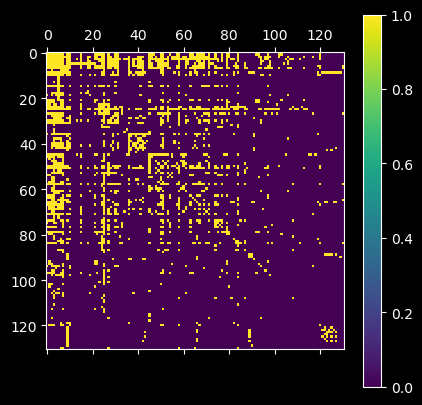

In [1]:
from dataset import Dataset
import matplotlib.pyplot as plt 
from utils import *
data = Dataset(root='../dataset', name='brazil', setting='GCN')
# plt.style.use('seaborn-bright')
adj, features, labels, init_adj = data.adj, data.features, data.labels, data.init_adj
adj, features, labels = preprocess(adj, features, labels, preprocess_adj=False, onehot_feature=False)

plt.matshow(adj.detach().cpu().numpy())
plt.colorbar()

Text(0.5, 0, 'NO norm Adj')

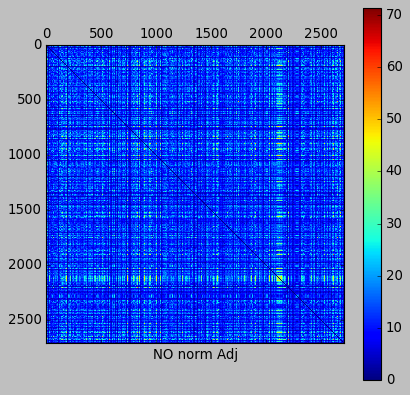

In [24]:
import torch 
adj_no_norm = torch.load('../inference_adj_NO_norm.pt')
plt.style.use('classic')

plt.matshow(adj_no_norm.numpy())
plt.colorbar()
plt.xlabel('NO norm Adj')

Text(0.5, 0, 'norm Adj')

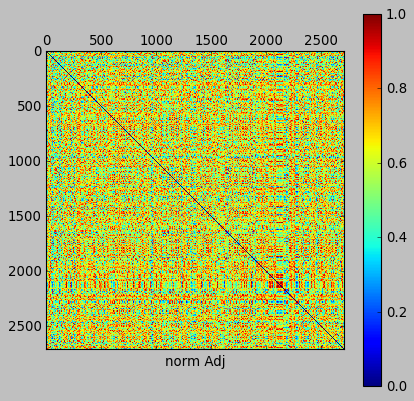

In [25]:
adj_norm = torch.load('../inference_adj_norm.pt')
plt.style.use('classic')
plt.matshow(adj_norm.numpy())
plt.colorbar()
plt.xlabel('norm Adj')

Loading brazil dataset...


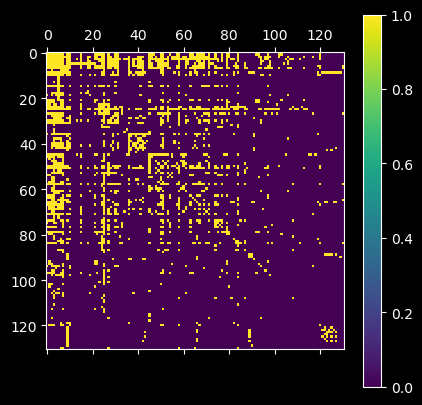

In [4]:
from dataset import Dataset
import matplotlib.pyplot as plt 
from utils import *
from dataset import Dataset

# 'cora', 'citeseer', 'AIDS', 'usair', 'brazil', 'polblogs', 'enzyme'
name = 'brazil'

data = Dataset(root='../dataset', name=name, setting='GCN')
# plt.style.use('seaborn-bright')
adj, features, labels, init_adj = data.adj, data.features, data.labels, data.init_adj
adj, features, labels = preprocess(adj, features, labels, preprocess_adj=False, onehot_feature=False)

plt.matshow(adj.detach().cpu().numpy())
plt.colorbar()


# Stastic

In [7]:
from dataset import Dataset
import matplotlib.pyplot as plt 
from utils import *
import numpy as np 

dataset_names = ['cora', 'citeseer', 'AIDS', 'usair', 'brazil', 'polblogs', 'enzyme']
# Classes Features Nodes Edges
for name in dataset_names:
    data = Dataset(root='../dataset', name=name, setting='GCN')
    adj, features, labels = data.adj, data.features, data.labels

    nodes = adj.shape[0]
    features_dim = features.shape[1]
    Classes = np.unique(labels).shape[0]
    Edges = np.nonzero(adj)[0].shape[0]

    print('Nodes:{}, Features:{}, Classes:{}, Edges:{}'.format(nodes, features_dim, Classes, Edges))


Loading cora dataset...
Nodes:2708, Features:1433, Classes:7, Edges:10556
Loading citeseer dataset...
Nodes:3312, Features:3703, Classes:6, Edges:9072
Loading aids dataset...
Nodes:1429, Features:4, Classes:14, Edges:2948
Loading usair dataset...
Nodes:1190, Features:1190, Classes:4, Edges:27164
Loading brazil dataset...
Nodes:131, Features:131, Classes:4, Edges:2077
Loading polblogs dataset...
Nodes:1490, Features:1490, Classes:2, Edges:33430
Loading enzyme dataset...
Nodes:6254, Features:18, Classes:3, Edges:23914
